In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from datetime import datetime
from requests import request
import json

import boto3
import sagemaker
from sagemaker import get_execution_role
import os
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.estimator import Estimator
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

In [2]:
sagemaker_session = sagemaker.Session()
role = get_execution_role()
bucket = sagemaker_session.default_bucket()

In [3]:
data_dir = 'json_stock_data'

if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
train_key = os.path.join(data_dir, 'train.json')
test_key = os.path.join(data_dir, 'test.json')

In [4]:
prefix = 'lambda-deepar-stock-forecasting'

train_prefix = f'{prefix}/train'
test_prefix = f'{prefix}/test'

In [5]:
image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')

In [6]:
start_date = '01/01/2019'
end_date = datetime.now()

start_timestamp = int(time.mktime(datetime.strptime(start_date, '%m/%d/%Y').timetuple()))
end_timestamp = int(datetime.timestamp(end_date))

In [7]:
def load_historical_data(freq, start, end, symbol):
    url = 'https://apidojo-yahoo-finance-v1.p.rapidapi.com/stock/v2/get-historical-data'
    
    query_string = {'frequency':freq,
                    'filter':'history',
                    'period1':start,
                    'period2':end,
                    'symbol':symbol
                   }
    
    headers = {'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com",
               'x-rapidapi-key': "06ea437b1fmsh826f67f4c8ebbdbp1f5284jsncb55b9f41a30"
              }
    
    response = request('GET', url, headers=headers, params=query_string)
    
    return response

In [8]:
data = []
stock_tickers = ['AAPL', 'MSFT', 'INTC', 'CSCO', 'ADBE', 'CRM', 'NVDA', 'ACN', 'IBM', 'ORCL', 'TXN', 'QCOM', 'ADP', 'INTU', 'MU', 'AMD', 'ADSK', 'HPQ', 'AMZN', 'GOOG']
for ticker in stock_tickers:
    data.append(load_historical_data('1d', start_timestamp, end_timestamp, ticker))

In [9]:
price_data = [json.loads(d.text)['prices'] for d in data]

In [10]:
time_series = []
for stock in price_data:
    data = []
    index = []
    for day in stock:
        if 'adjclose' in day:
            data.append(day['adjclose'])
            index.append(datetime.fromtimestamp(day['date']))
    data.reverse()
    index.reverse()
    time_series.append(pd.Series(data=data, index=index))
    print(len(data))

287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287


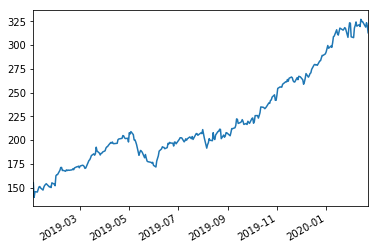

In [11]:
time_series[0].plot()
plt.show()

In [12]:
vix_data = load_historical_data('1d', start_timestamp, end_timestamp, '^VIX')

In [13]:
vix_price_data = json.loads(vix_data.text)['prices']
v_data = []
v_index = []
for day in vix_price_data:
    if 'adjclose' in day:
        v_data.append(day['adjclose'])
        v_index.append(datetime.fromtimestamp(day['date']))
v_data.reverse()
v_index.reverse()
vix_time_series = pd.Series(data=v_data, index=v_index)

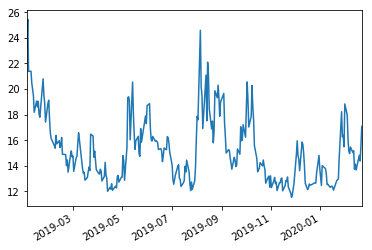

In [14]:
vix_time_series.plot()
plt.show()

In [15]:
prediction_length = 30

time_series_training = []
for ts in time_series:
    time_series_training.append(ts[:-prediction_length])

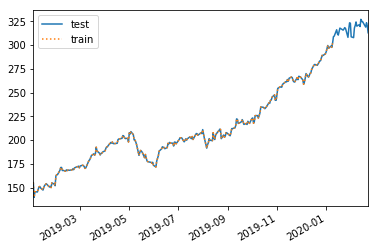

In [16]:
time_series[0].plot(label='test')
time_series_training[0].plot(label='train', ls=":")
plt.legend()
plt.show()

In [17]:
def series_to_obj(ts, dynamic_feat):
    return {'start': str(ts.index[0]),
            'target': list(ts),
            'dynamic_feat': [list(dynamic_feat)]
           }

def series_to_jsonline(ts, dynamic_feat):
    return json.dumps(series_to_obj(ts, dynamic_feat))

def write_json_dataset(ts, filename, dynamic_feat, encoding='utf-8'):
    with open(filename, 'wb') as f:
        for t in ts:
            f.write(series_to_jsonline(t, dynamic_feat).encode(encoding))
            f.write('\n'.encode(encoding))
        print(filename, 'saved')

In [18]:
write_json_dataset(time_series_training, train_key, vix_time_series[:-prediction_length])
write_json_dataset(time_series, test_key, vix_time_series)

json_stock_data/train.json saved
json_stock_data/test.json saved


In [19]:
train_path = sagemaker_session.upload_data(train_key, bucket=bucket, key_prefix=train_prefix)
test_path = sagemaker_session.upload_data(test_key, bucket=bucket, key_prefix=test_prefix)